## Bnadit Problem
### Adviser: Brown Nicholas   
### Author: Jiachi Sun

The multi-armed slot machine problem refers to how we can maximize the overall reward over time by balancing exploration-digging.

### The code below sets the necessary import and standard k-arm bandit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret


### The code below implement the Thompson Sampling with beta-distribution.

In [2]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()


### The code below implement the $\epsilon$-Greedy algorithm

In [3]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

### The code below implement the UCB algorithm.

In [4]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### The code below implement the Random Sampling algorithm.

In [2]:
# The code of random I wrote is base on the EpsilonGreedy since if when epsilon = 1, the algorithm will be random.
class RandomSampling():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'random-sampling'
  
  def get_action(self):
    action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### Here is some helper methods.

In [6]:

def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
# EpsilonGreedy, UCB, BernThompson, RandomSampling,
  algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

### Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling?
- __Thompson Sampling__  
    - Do not have hyperparameters.  
    ***
    
- __$\epsilon$-Greedy__  
    - The hyperparameter for $\epsilon$-greedy is the $\epsilon$
    - The $\epsilon$ determines the probability of whether we choose to exploration or exploitation for each round.If we set $\epsilon$ to 1,the $\epsilon$-greedy algorithm will like random sampling.If we set $\epsilon$ to 0.1, then there is a 10% probability that one restaurant will be randomly selected for exploration each time. There is a 90% probability of choosing the one with the highest current return.  
    - We can see from the two sets of experiments below that the experimental results differ greatly when we set $\epsilon$ to 0.1 and 0.03, respectively. When $\epsilon$ is 0.1, both $\epsilon$-greedy and Thompson Sampling can be stabilized at about 200 times. However, when we set $\epsilon$ to 0.03, $\epsilon$-greedy converge to a steady regret value after 800 steps.
    ***
- __UCB__  
    - The hyperparameter for UCB is the constant c.
    - The larger we set the value of c, the smaller the weight of $Q_t(a)$. Also, the larger the value of c is set, the more the UCB algorithm focuses on exploration.
    - From the comparison of the two sets of experiments below we can find that the value of the constant c has a very strong influence on the UCB. When we set c to 2, the UCB algorithm does not stabilize until the 1000th time. But when we set C to 0.1, UCB performs very well and converge to a steady regret value at 100 steps.
    ***
- __Random Sampling__  
    - Do not have hyperparameters.  
    ***

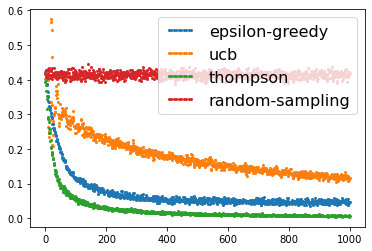

In [7]:

# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

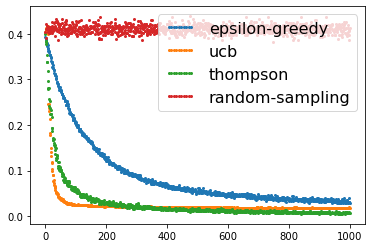

In [8]:
# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(arm_count)

### How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling?
- We set arm_count to 200, and we can see by the following experiments that UCB becomes very unstable and Thompson Sampling takes longer to stabilize, but $\epsilon$-Greedy still tends to stabilize after 200 steps. It is also worth noting that after 700 steps, Thompson Sampling's regret value starts to be lower than $\epsilon$-Greedy.
***
- The reason why UCB is so unstable is that we set the constant $c$ to 2, which leads to a large weight of exploration behavior in UCB, and we have a large action space, which leads to a strong emphasis on exploration in UCB. At the same time probably many of the returns are very low. Resulting in the final result looks very volatile.
***
- Thompson Sampling did not behave as erratically as UCB did. But it did take about 1500 steps to converge to a stable regret value. The reason for this is that Thompson Sampling is based on a Beta distribution and does not fluctuate as much as UCB.
***
- The reason that $\epsilon$-Greedy is the most stable among several algorithms is that $\epsilon$-Greedy does not give high weight to unexplored actions as Thompson Sampling and UBC do. Rather, it will have a higher probability of choosing the current optimal choice.
***
- Random sampling is not influenced by action space. This is because his sampling is completely random and independent of any variable.
***
- Finally, it is worth mentioning that after we increased the number of steps to 3000 and lowered the value of $c$ in UCB to 0.01, UCB got the smallest regret value with arm of 200; Thompson Sampling took longer to stabilize but the regret value was not much different from the UCB. $\epsilon$-Greedy stabilized the fastest but the regret value was much higher than the other two.
***

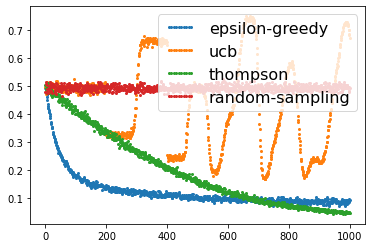

In [9]:
# Experiment 3
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

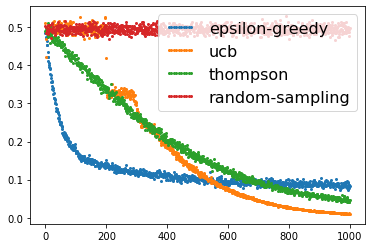

In [10]:
# Experiment 4
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count)

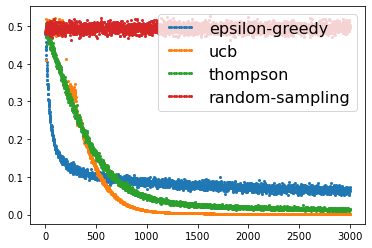

In [11]:
# Experiment 5
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)


### How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling?
- Comparing Experiment 6 and Experiment 7, we set $arm count = 10, epsilon = 0.6, ucb c = 0.1$ And the only different between these two is that in Experiment 6 we set $stationary=True$ for Experiment 7 $stationary=False$
***
- __Thampson Sampling__
    - The regret value can be quickly reduced after each reset. But overall, the minimum regret value that T can reach is gradually increasing as the reward distribution starts to be refreshed.This is because Thampson Sampling changes the values of a and b of the beta distribution of the corresponding restaurant based on each result. And when we reset the restaurant, the values of a and b for each restaurant are not changed.This takes more time to modify the previously derived results, which means we need more steps to reduce the disappointment value. But every 100 steps, we will refresh again, which means our disappointment value will be higher and higher.
***
- __$eplison$-Greedy__
    - The overall trend is very similar to Thampson Sampling. Meanwhile, after each refresh, the lowest regret value reached by $eplison$-Greedy is gradually approaching that of Thampson Sampling. The gap between the regret values of $eplison$-Greedy and Thampson Sampling is gradually decreasing. When the random number is greater than $eplison$, $eplison$-Greedy will choose the restaurant based on the previous result. But by this time the machine has been refreshed, and it may be wrong for us to still select based on the previous data at this point. And because we do not reset the collected data of $eplison$-Greedy, it takes longer to learn, which leads to worse and worse results.
***
- __UCB__
    - The performance of UCB, which emphasizes exploration the most, was excellent. It can be seen that although the performance of UCB at the beginning is not as good as $eplison$-Greedy and Thampson Sampling but after each refresh, the performance of UCB is getting better and better compared to before, and the final performance is better than $eplison$-Greedy and Thampson Sampling. This because our c value is set to 2 which is very large, which means that UCB will place more emphasis on exploration. This is very advantageous when $stationary=False$, and is the reason why UCB performs so well.Which can also be observed from Experiment 8, we adjusted ucb_c to 0.1. This time the exploration weight of UCB is low and the performance became worse and worse. When stationary=False, the more emphasis on exploration the better the results will perform 
***
- __Random Sampling__
    - The stationary do not affect the Random Sampling.
***

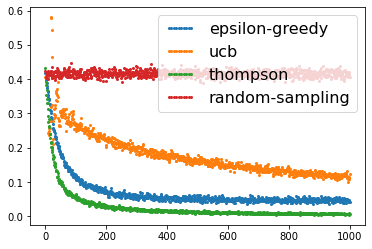

In [12]:
# Experiment 6
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

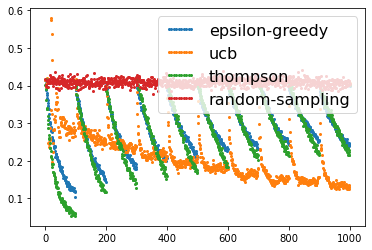

In [13]:
# Experiment 7
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

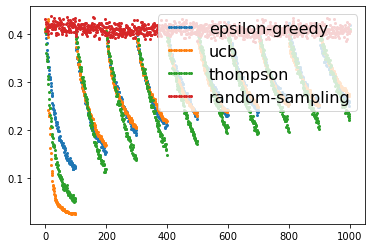

In [14]:
# Experiment 8
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.1
stationary=False
experiment(arm_count)

### When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring?
- __Thompson Sampling__
    - For Thompson Sampling, it stop exploring when each restaurant's beta distribution have no intersection area. In this case, Thompson Sampling will always choose the one with largest theta value.
***
- __$\epsilon$-Greedy__
    - For $\epsilon$-Greedy, it stop exploring when we set the $\epsilon=0$, in this case, $\epsilon$-Greedy while always the one have the largest Q value. Otherwise, $\epsilon$-Greedy will not stop exploring.
***
- __UCB__
    - For UCB, it will stop exploring when, with the exploring, the confidence boundary shrinks to the point Q and UBC will choose the restaurant only base on the Q value.
***
- __Random Sampling__
    - For random sampling, it will not stop exploring. And do not depend on any value.
***
- __Exploration-Exploitation tradeoff__
    - The exploration-exploitation trade-off is to allocate our resources to maximize benefits (minimize regret) between __make the decision to explore what may not seem like the best option at the moment to learn more information__ and __exploiting to get the interests based on the information we have already__.

### How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions?
- __Thompson Sampling__
    - Thampson Sampling will always remember the past actions by update the $\alpha$ and $\beta$ value of the machine's beta distribution. Such as, for any machine A, $\alpha$ is the number of times restaurant A tastes good, $\beta$ is the number of times restaurant A tastes bad.
- __$\epsilon$-Greedy__
    - The $\epsilon$-Greedy will remember the past actions by change the $Q$ value base on the reward. And the $N$ value which is the number of game of a machine.
- __UCB__
    - The UCB remember the past action since it will update the $Q$ value of the machine base on the reward and the $N$ value(number of games of a machine) used to calculate the upper confidence bound. And also, the total number of steps-timestep.
- __Random sampling__
    - Random sampling do not remember the past actions, it always randomly choose the restaurant. 

### Reference:
1. Andre Cianflone - Thompson sampling
https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb


### License
MIT License

Copyright (c) 2022 Jiachi Sun

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.